## 2章 Open Bandit Datasetを用いた意思決定モデルの学習/評価の実装

この実装例は主に次の3つのステップで構成される。

1. データの前処理: Open Bandit DatasetのうちBernoulliTSモデルで収集されたデータを読み込んで前処理を施す。
2. 意思決定モデルの学習: トレーニングデータを用いてIPWLearnerに基づいた意思決定モデルを学習し、バリデーションデータに対して行動を選択する。
3. 意思決定モデルの性能評価: 学習された意思決定モデルの性能をバリデーションデータを用いて評価する。

このような分析手順を経ることにより「**ZOZOTOWNのファッションアイテム推薦枠において、データ収集時に使われていたBernoulliTSモデルをこれからも使い続けるべきなのか、はたまたOPLで新たに学習したIPWLearnerに基づく意思決定モデルへの切り替えを検討すべきなのか**」という問いに答えることを目指す。

In [1]:
# 必要なパッケージをインポート
from pathlib import Path

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import obp
from obp.dataset import OpenBanditDataset
from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    InverseProbabilityWeighting as IPS,
    DoublyRobust as DR
)

## (1) Data Loading and Preprocessing

[Open Bandit Dataset（約11GB）](https://research.zozo.com/data.html)をダウンロードし、"./open_bandit_dataset"におく。

In [2]:
# ZOZOTOWNのトップページ推薦枠でBernoulli Thompson Sampling (bts)が収集したデータをダウンロードする
# `data_path=None`とすると、スモールサイズのお試しデータセットを用いることができる
dataset = OpenBanditDataset(
    behavior_policy="bts", # データ収集に用いられた意思決定モデル
    campaign="men", # キャンペーン. "men", "women", or "all" ("all"はデータ数がとても多いので注意)
    data_path=Path("./open_bandit_dataset"), # データセットのパス
)

# デフォルトの前処理を施したデータを取得する
# タイムスタンプの前半70%をトレーニングデータ、後半30%をバリデーションデータとする
training_data, validation_data = dataset.obtain_batch_bandit_feedback(
    test_size=0.3,
    is_timeseries_split=True
)

# training_dataの中身を確認
training_data.keys()

/Users/usaito/.pyenv/versions/3.8.2/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


dict_keys(['n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context'])

In [3]:
# 行動（ファッションアイテム）の数
dataset.n_actions

34

In [4]:
# データ数
dataset.n_rounds

4077727

In [5]:
# デフォルトの前処理による特徴料の次元数
dataset.dim_context

27

In [6]:
# 推薦枠におけるポジションの数
dataset.len_list

3

### 意思決定モデルの学習

トレーニングデータを用いてIPWLearnerとランダムフォレストの組み合わせに基づく意思決定モデルを学習し、バリデーションデータに対して行動を選択する。

In [7]:
%%time
# 内部で用いる分類器としてランダムフォレストを指定したIPWLearnerを定義する
new_decision_making_model = IPWLearner(
    n_actions=dataset.n_actions, # 行動の数
    len_list=dataset.len_list, # 推薦枠の数
    base_classifier=RandomForestClassifier(
        n_estimators=300, max_depth=10, min_samples_leaf=5, random_state=12345
    ),
)

# トレーニングデータを用いて、意思決定意思決定モデルを学習する
new_decision_making_model.fit(
    context=training_data["context"], # 特徴量（X_i）
    action=training_data["action"], # 過去の意思決定モデルによる行動選択
    reward=training_data["reward"], # 観測される目的変数
    position=training_data["position"], # 行動が提示された推薦位置（ポジション）
    pscore=training_data["pscore"], # 過去の意思決定モデルによる行動選択確率(傾向スコア)
)

# バリデーションデータに対して行動を選択する
action_dist = new_decision_making_model.predict(
    context=validation_data["context"],
)

CPU times: user 4min 3s, sys: 24.7 s, total: 4min 27s
Wall time: 4min 28s


### 意思決定モデルの性能評価
学習した新たな意思決定モデル(IPWLearner)の性能を、バリデーションデータとIPWおよびDR推定量により評価する。

In [8]:
%%time
# DR推定量を用いるのに必要な目的変数予測モデルを得る
# opeモジュールに実装されている`RegressionModel`に好みの機械学習手法を与えば良い
regression_model = RegressionModel(
    n_actions=dataset.n_actions, # 行動の数
    len_list=dataset.len_list, # 推薦枠内のポジションの数
    base_model=LogisticRegression(C=100, max_iter=10000, random_state=12345), # ロジスティック回帰を使用
)

# `fit_predict`メソッドにより、バリデーションデータにおける期待報酬を推定
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=validation_data["context"], # 特徴量（X_i）
    action=validation_data["action"], # 過去の意思決定モデルによる行動選択
    reward=validation_data["reward"], # 観測される目的変数
    position=validation_data["position"], # 行動が提示された推薦位置（ポジション）
    random_state=12345,
)

CPU times: user 6min 54s, sys: 1min 43s, total: 8min 38s
Wall time: 2min 4s


In [9]:
# 意思決定モデルの性能評価を一気通貫で行うための`OffPolicyEvaluation`を定義する
ope = OffPolicyEvaluation(
    bandit_feedback=validation_data, # バリデーションデータ
    ope_estimators=[IPS(), DR()] # 使用する推定量
)

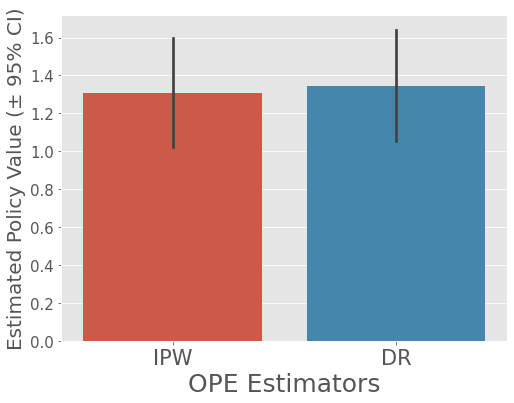

In [10]:
# 内部で用いる分類器としてロジスティック回帰を指定したIPWLearnerの性能をOPEにより評価
ope.visualize_off_policy_estimates(
    action_dist=action_dist, # evaluation_policy_aによるバリデーションデータに対する行動選択
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    is_relative=True, # 過去の意思決定モデルの性能に対する相対的な改善率を出力
    random_state=12345,
)

ここで得られた意思決定モデルの性能評価の結果から、データ収集時に用いられていたBernoulliTSモデルからIPWLearnerによる特徴量の情報を活用した個別化推薦に切り替えることで、クリック確率（意思決定モデルの性能）を30%程度向上させられる可能性が示唆された。IPWLearnerの性能について推定された95%信頼区間の下限も、1.0付近（ベースラインであるBernoulliTSモデルの性能と同程度）であるため、大きな失敗はしなさそうである。この性能評価の結果に基づき、IPWLearnerを実環境にいきなり導入したり、IPWLearnerが有望な意思決定モデルであることに対して自信を持った上で、安全にA/Bテストに進んだりできる。